In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from helpers import *
from proj1_helpers import *


## Load the training data into feature matrix, class labels, and event ids:

In [2]:

DATA_TRAIN_PATH = '../Data/train.csv' # TODO: add a file Data-Project1 with the train data 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

# Preprocess the data

In [3]:
# Delete the outliers with the median
def delete_outliers(tX):
    for idx_feature in range(tX.shape[1]):
        tX_feature = tX[:,idx_feature]
        median = np.median(tX_feature[np.where(tX_feature != -999)])
        new = np.where(tX_feature == -999, median, tX_feature)
        tX[:, idx_feature] = np.copy(new)
    return tX

In [4]:
tX = delete_outliers(tX)

In [5]:
# Standardize the data
stx, mean_stx, std_x = standardize(tX)

In [6]:
# y must be 0 or 1 and not -1 or 1
def set_y(y):
    y = np.where(y == -1, 0, y)
    return y
y = set_y(y)

Get rid of the Features that do not provide any more information than the background

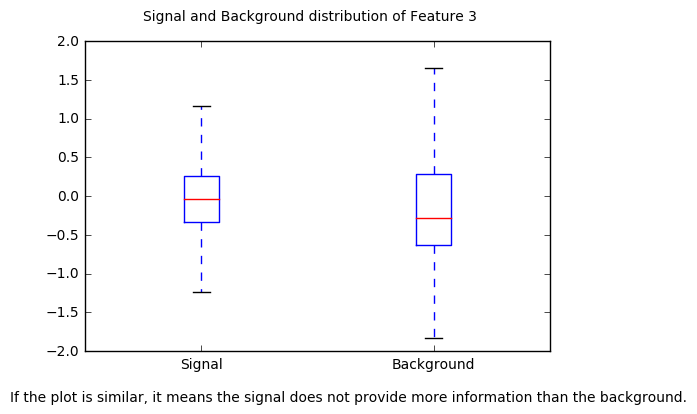

In [7]:
idx_f = 2
signal = stx[np.where(y == 1), idx_f + 1]
background = stx[np.where(y == 0), idx_f + 1]

plot = plt.figure()
plt.boxplot([signal, background], 0, '')
plt.xticks([1, 2], ['Signal', 'Background'])
plot.suptitle('Signal and Background distribution of Feature {f}'.format(f = idx_f + 1))

textvar = plot.text(0, 0, 'If the plot is similar, it means the signal does not provide more information than the background.')

In [23]:
# Initialize parameters
gamma = 1e-6
lambda_ = 0.001
max_iters = 100

# Calculate Prediction estimate

In [41]:
def divide_training_data(y, x, ratio ):
    """Divide a dataset into 2 disjoint parts. We will use this on the training data set 
    so that we can train on one and test on the other to check the accuracy of our prediction
    """
    indices = np.random.choice(np.arange(len(y)), int( len(y)*ratio ), replace=False)
    
    # training data 
    x_train = x[indices]
    y_train = y[indices]
    
    # test data 
    x_test = x[~indices]
    y_test = y[~indices]
    


    return x_train, x_test, y_train, y_test

In [62]:
def prediction( y, tX, gamma, max_iters, lambda_  ):
    # divide data
    x_train, x_test, y_train, y_test = divide_training_data(y, tX, 0.5 )
    
    loss = 0
    w = []
    loss, w = logistic_regression(y_train, x_train, gamma, max_iters)
    
    y_pred = predict_labels(w, x_test)    
    y_pred = set_y(y_pred)
    
    # accuracy of the prediction
    N = y_test.shape
    print(N, y_pred.shape)
    pred = np.sum(y_pred == y_test)/N[0]
        
    return pred

In [63]:
prediction(y, stx, 0.00001, 200, 0 )

Current iteration=0, the loss=[[ 86643.39756999]]
(125000,) (125000,)


0.75096799999999997

## Linear regression using Gradient Descent 

In [12]:
from costs import *

def compute_gradient(y, tx, w):
    """Compute the gradient."""
    e = y - tx @ w
    return -(tx.T @ e)/len(y)

def linear_regression_GD(y, tx, gamma, max_iters):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    w = np.zeros(tx.shape[1])
    ws = [np.copy(w)]
    losses = []
    for n_iter in range(max_iters):
        # compute gradient with mse
        grad = compute_gradient(y, tx, w)
        
        # update w
        w = w - (gamma*grad)
        
        # calculate the cost with mse
        loss = compute_loss(y, tx, w)
        
        # store w and loss
        ws.append(np.copy(w))
        losses.append(loss)
    print("Optimal weights: {w}".format(w=ws[tx.shape[1]]), "\n Loss: {loss}".format(loss = loss))
    return ( loss, w )



Loss for Linear Regression using Gradient Descent

In [49]:
gamma = 0.001
max_iters = 100
losses, ws = linear_regression_GD(y, stx, gamma, max_iters)

Optimal weights: [  1.04648969e-02   3.75362625e-04  -4.99656749e-03  -1.91176313e-04
   2.60325480e-03   2.83333842e-03   2.92009580e-03  -2.53973496e-03
   2.92672884e-04  -2.91997173e-04   2.02535218e-03  -2.78308290e-03
   3.80261289e-03   2.46044555e-03   3.29369359e-03  -1.44874300e-05
  -6.42817694e-05  -4.79514601e-04   1.95107674e-05   5.97363034e-05
   2.21582085e-04   1.05131123e-04   1.77564564e-03   1.77070788e-03
   1.50527857e-03   9.97254502e-07   1.20346588e-05   2.19947304e-04
   8.90938540e-06  -4.90302043e-05   1.74571674e-03] 
 Loss: 0.15160026197005938


## Linear regression using stochastic gradient descent

In [26]:
def linear_regression_SGD(y, tx, gamma, max_iters):
    """Stochastic gradient descent algorithm."""
    # Define parameters to store w and loss
    w = np.zeros(tx.shape[1])
    ws = [np.copy(w)]
    losses = []
    batch_size = 50000
    
    for n_iter in range(max_iters):
        # compute gradient for each ini batch
        a = 0;
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size, num_batches=1):
            grad = compute_gradient(minibatch_y, minibatch_tx, w)
            
            # upgrade w
            w = w - (gamma*grad)

            # compute loss with mse
            loss = compute_loss(y, tx, w)

            # store w and loss
            ws.append(np.copy(w))
            losses.append(loss)
    print("Optimal weights: {w}\n\n Loss: {l}".format(w=ws[tx.shape[1]], l = loss))
    return loss, w


In [28]:
losses, ws = linear_regression_SGD(y, stx, gamma, max_iters)
w_LSSGD = ws[-1]
w_LSSGD = w_LSSGD[1:]

Optimal weights: [  1.04705105e-02   3.79845674e-04  -4.97651176e-03  -1.94235207e-04
   2.63344112e-03   2.81190678e-03   2.90083034e-03  -2.52081839e-03
   2.80011928e-04  -2.86502247e-04   2.03850299e-03  -2.76886684e-03
   3.82063932e-03   2.45931692e-03   3.29498777e-03  -2.14715757e-05
  -6.96247980e-05  -4.62731675e-04   2.84074841e-05   6.06792421e-05
   2.59777250e-04   1.27353977e-04   1.78733661e-03   1.77304161e-03
   1.52269183e-03   1.33327211e-05   7.02572929e-06   2.16524382e-04
   4.10631762e-06  -6.96207410e-05   1.75716700e-03]

 Loss: 0.15160312268989676


## Least squares regression using normal equations

In [ ]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    w = np.linalg.solve(tx.T @ tx, tx.T @ y)
    return w, compute_loss(y, tx, w)

least_squares(y, stx)

## Ridge regression using normal equations

In [ ]:
def ridge_regression(y, tx, lamb):
    """implement ridge regression."""
    w = np.linalg.solve((tx.T @ tx) + lamb*np.eye(tx.shape[1]), tx.T @ y)
    return w, compute_loss(y, tx, w)

lamb = 0
weights, loss = ridge_regression(y, stx, lamb)
weights = weights[1:]
print(loss)

## Logistic regression using gradient or SGD

In [27]:
def sigmoid(t):
    """apply sigmoid function on t."""
    # equivalent to use 1/(1+exp(-t)) but avoids overflow
    return np.exp(-np.logaddexp(0, -t))

In [28]:
def calculate_loss(y, tx, w):
    """compute the cost by negative log likelihood."""
    #for n in range(N):
    #   cost += np.log(1+np.exp(tx[n, :].T @ w)) - (y[n] * tx[n, :].T @ w)
    y = y.reshape((-1, 1))
    return np.sum(np.logaddexp(0, tx @ w)) - y.T @ (tx @ w)

In [29]:
def calculate_gradient(y, tx, w):
    """compute the gradient of loss."""
    sig = sigmoid(tx @ w)
    sig = sig.reshape(sig.shape[0],)
    return tx.T @ (sig - y)

In [30]:
def learning_by_gradient_descent(y, tx, w, gamma, lambda_):
    """
    Do one step of gradient descent using logistic regression.
    Return the loss and the updated w.
    """
    loss = calculate_loss(y, tx, w) + lambda_* (w.T @ w)
    gradient = calculate_gradient(y, tx, w)
    
    w.shape = (w.shape[0],)
    w = w - gamma * gradient
    return loss, w

In [33]:
def logistic_regression(y, tx, gamma, max_iters):
    """
    Logistic regression using GD
    """
    # init parameters
    threshold = 0.001
    losses = []

    # build w
    w = np.zeros((tx.shape[1], 1))
    
    # y must be 0 or 1 and not -1 or 1(as implemented in the lab)
    y = np.where(y == -1, 0, y)

    # start the logistic regression
    for iter in range(max_iters):
        # get loss and update w.
        loss, w = learning_by_gradient_descent(y, tx, w, gamma, lambda_ = 0)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
        # converge criteria ( max_iters is really high)
        losses.append(np.copy(loss))
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    return loss, w



In [ ]:
max_iters = 10000
loss_LR, w_LR = logistic_regression(y, stx, gamma, max_iters)

## Regularized  logistic  regression  using  gradient  descent or SGD

In [ ]:
def reg_logistic_regression(y, tx, lambda_, gamma, max_iters):
    """
    Logistic regression using GD
    """
    # init parameters
    threshold = 0.01
    losses = []

    # build w
    w = np.zeros((tx.shape[1], 1))

    # start the logistic regression
    for iter in range(max_iters):
        # get loss and update w.
        loss, w = learning_by_gradient_descent(y, tx, w, gamma, lambda_)
        # log info
        if iter % 500 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
        # converge criteria ( max_iters is really high)
        losses.append(np.copy(loss))
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    return loss, w

reg_logistic_regression(y, stx, lambda_, gamma, max_iters)

## Cross Validation

Take the minimum of rmse_te

In [ ]:
from cross_validation import *
seed = 1
k_fold = 4
lambdas = np.logspace(-4, 2, 30)
cross_validation_demo(y, stx, k_fold, lambdas, seed)

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '../../../Data-Project1/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
stx_test, mean_stx_test, std_x_test = standardize(tX_test)

In [ ]:
OUTPUT_PATH = '../../../Data-Project1/Data_submission.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(w_LR, stx_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)